In [1]:
using ApproxFun
using SpecialFunctions

using LinearAlgebra
using SparseArrays

include("../src/Chebyshev.jl")
import .Chebyshev as CH

import Plots
using Plots

# use PyCall
using PyCall
@pyimport qnm

import HDF5

include("../src/SpectralRadialODE.jl")
import .SpectralRadialODE as RODE
using GenericLinearAlgebra # for svd of bigfloat matrix

# Teukolsky Radial Equation

In [63]:
# input params

nr = 80
s = -2;
l = 2;
m = 2;
n = 7;
T=BigFloat
a = T(0.999);
bhm = T(1);

rmin = T(0); ## location of future null infinity (1/r = ∞)
rmax = abs(a) > 0 ? (bhm / (a^2)) * (1 - sqrt(1 - ((a / bhm)^2))) : 0.5 / bhm;

In [64]:
mode_seq = qnm.modes_cache(s=s,l=l,m=m,n=n);
omega, lambda, C = mode_seq(a=Float64(a));


In [65]:
M = RODE.radial_operator(nr,s,l,m,n,a,bhm,rmin,rmax);
rs = CH.cheb_pts(rmin,rmax,nr);
null = nullspace(Matrix(M),rtol=1e-10);
vect = CH.to_real(null[:,end]);

In [66]:
D1 = CH.mat_D1(rmin,rmax,nr);

In [67]:
amp = [abs(v/vect[end]) for v in vect];
#D = CH.mat_D1(rmin,rmax,nr);

In [68]:
damp = D1*amp;

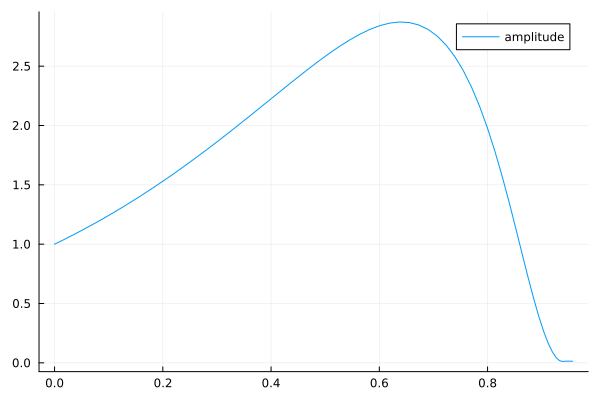

In [69]:
Plots.plot(rs,[abs(v) for v in amp],label="amplitude")
#Plots.plot!(rs,[v for v in damp],label="amplitude derivative")


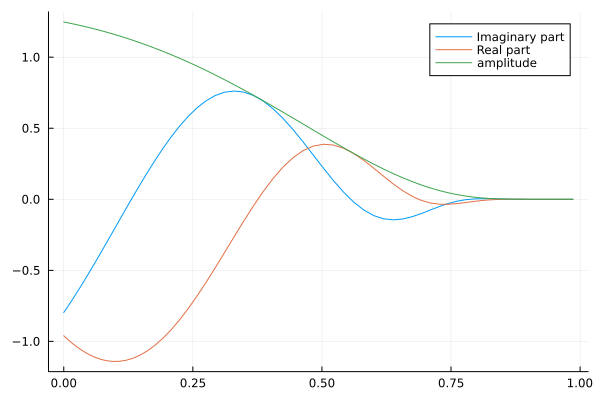

In [52]:
Plots.plot(rs,[v.im for v in vect],label="Imaginary part")
Plots.plot!(rs,[v.re for v in vect],label="Real part")
Plots.plot!(rs,[abs(v) for v in vect],label="amplitude")


# Save the resulting files

In [75]:
function save_to_file!(
    prename::String,
    n::Integer,
    l::Integer,
    m::Integer,
    a::T,
    #omega::ComplexF64,
    #lambda::ComplexF64,
    vr::Vector{<:Complex{T}},
    rs::Vector{<:T},
    amp::Vector{<:T},
    damp::Vector{<:T},
) where {T<:Real}
    fname = "$(pwd())/qnmfiles/$(prename)a$(a)_l$(l)_m$(m)_n$(n)"
    HDF5.h5open("$fname.h5", "cw") do file
        g = HDF5.create_group(file, "[a=$(convert(Float64,a)),l=$(convert(Int64,l))]")
        g["nr"] = convert(Int64, length(rs))
        #g["omega"] = convert(ComplexF64, omega)
        #g["lambda"] = convert(ComplexF64, lambda)
        g["radial_func"] = [convert(ComplexF64, v) for v in vr]
        g["rvals"] = [convert(Float64, v) for v in rs]
        g["amp"] = [convert(Float64, v) for v in amp]
        g["damp"] = [convert(Float64, v) for v in damp]
    end
    return nothing
end;

In [82]:
nr = 160;
nr_interp = 300;

In [87]:
for n=0:12
    M = RODE.radial_operator(nr,s,l,m,n,a,bhm,rmin,rmax);
    rs = CH.cheb_pts(rmin,rmax,nr_interp);
    null = nullspace(Matrix(M),rtol=1e-10);
    null_interp = zeros(Complex{T},nr_interp);
    null_interp[1:nr] = null[:,end];
    vect = CH.to_real(null_interp);
    amp = [abs(v/vect[end]) for v in vect];
    println(n)
    D = CH.mat_D1(rmin,rmax,nr_interp);
    damp = D*amp;
    save_to_file!("",n,l,m,a,vect,rs,amp,damp)
end

0
1
2
3
4
5
6
7
8
9
10
11
12
